# Crash Course in Causality: Causal Analysis of Study Time and Student Performance

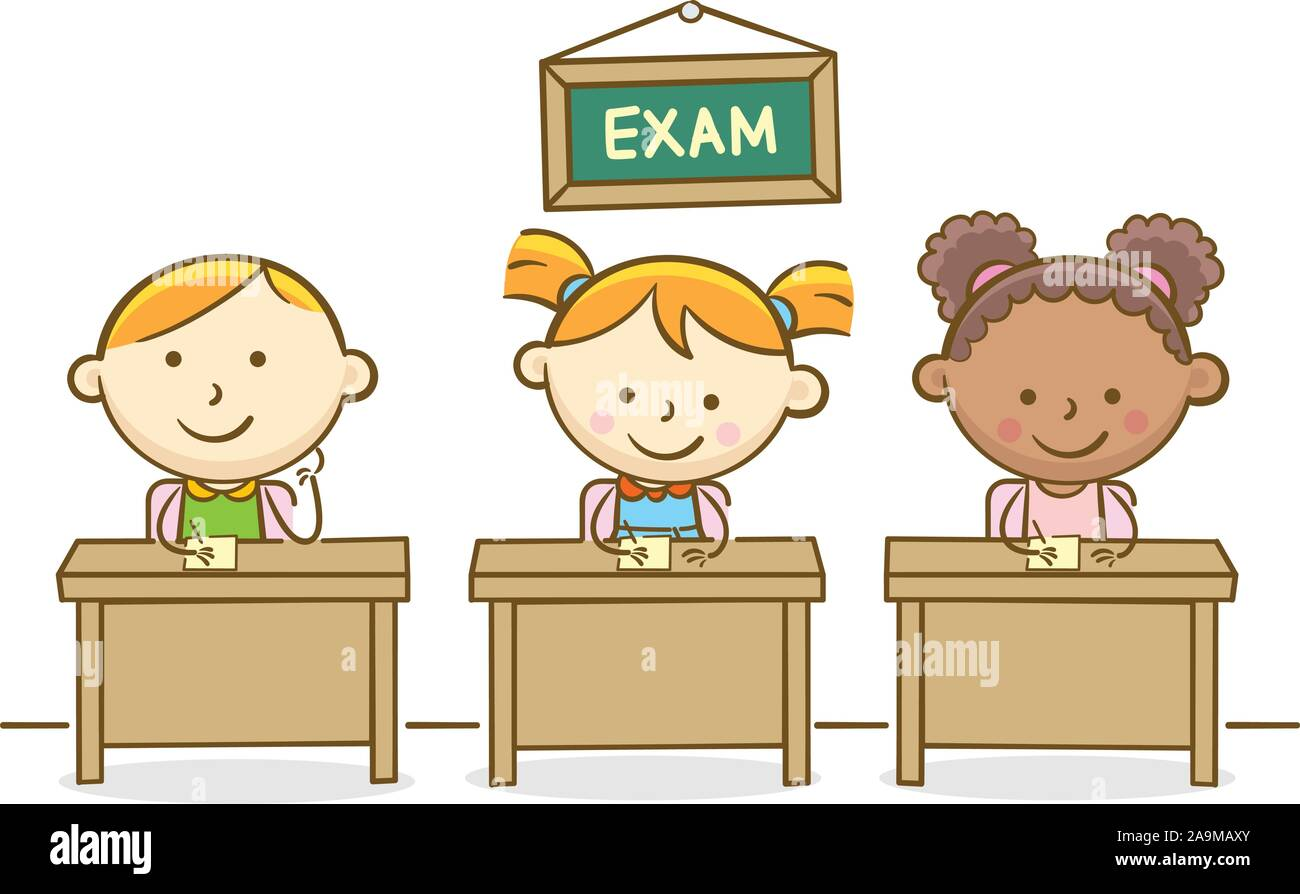

## Abstract

Understanding causality is essential for moving beyond correlations in machine learning and deriving actionable insights. This project delves into the critical role of data preparation in causal analysis. Key steps, including handling missing data, feature selection, and encoding categorical variables, are covered.

Using the Student Performance dataset, we examine the causal impact of study time (`studytime`) on final grades (`G3`). A Directed Acyclic Graph (DAG) models the relationships, and the `DoWhy` library estimates the causal effect. Robustness checks (placebo tests, subset refutations) validate findings.

Key results include:
- **Average Treatment Effect (ATE)**: For each additional unit of study time, the final grade increases by approximately **0.72 points**.
- **Subgroup Insights**: The causal effect of study time is stronger for students with fewer prior failures.

By the end of this notebook, readers will have a comprehensive understanding of how data preparation and causal analysis can provide actionable insights, with practical steps for implementation in Python.


## Before Loading the Dataset


This project uses the Student Performance dataset to study how students' study time (`studytime`) affects their final grades (`G3`).

### Dataset Overview
- `studytime`: Weekly study time.
- `G3`: Final grades (outcome).
- Confounders include `failures`, `absences`, `health`, `freetime`, and `goout`.

The goal is to determine the causal effect of `studytime` on `G3`.


## Theory

### 1. What is Causality?
Causality focuses on understanding how one variable directly affects another. Unlike correlation, which only shows associations, causality answers "what if" questions.

**Example:**  
- What if a student increased their study time? How would their final grades change?

The cornerstone of causal analysis is the distinction between:
- **Treatment Variable:** The variable under analysis (e.g., `studytime`).
- **Outcome Variable:** The result of interest (e.g., `G3` - final grades).
- **Confounders:** Variables influencing both the treatment and the outcome (e.g., absences, health).

---

### 2. Why Data Preparation is Crucial for Causal Analysis
Causal inference relies on clean, structured data to isolate causal effects. Key steps include:

#### a. Handling Missing Data
- Missing data can bias estimates. Approaches include:
  - **Mean/Mode Imputation**: Filling missing values with averages.
  - **Predictive Imputation**: Using ML models to estimate missing values.

#### b. Encoding Categorical Variables
- Convert categories into numeric representations:
  - **One-hot Encoding:** Creates binary columns for each category.
  - **Label Encoding:** Assigns numerical values to categories.

#### c. Feature Selection in Causal Frameworks
- Identify and control for confounders to avoid biased estimates.

#### d. Robustness Validation
- Validation techniques, such as placebo tests and subset refutations, assess the reliability of causal estimates.


# 1. Loading the Dataset

Step 1: Load and Explore the Dataset
Details:

The dataset is loaded using pandas.read_csv and stored in the df DataFrame.
The delimiter is ";" since the file is semicolon-separated.
df.head() is used to preview the first few rows of the data.

In [2]:
import pandas as pd
!pip install dowhy

from dowhy import CausalModel
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalled Cython-3.0.11


In [3]:
from google.colab import files

uploaded = files.upload()

# Load the dataset
file_name = list(uploaded.keys())[0]  # Get the name of the uploaded file
df = pd.read_csv(file_name)

Saving student-por.csv to student-por.csv


In [4]:
# Display basic information and the first few rows of the dataset
print("Dataset Shape:", df.shape)
print("Dataset Columns:", df.columns.tolist())
df.head()


Dataset Shape: (649, 1)
Dataset Columns: ['school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3']


,school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3
0,"GP;""F"";18;""U"";""GT3"";""A"";4;4;""at_home"";""teacher..."
1,"GP;""F"";17;""U"";""GT3"";""T"";1;1;""at_home"";""other"";..."
2,"GP;""F"";15;""U"";""LE3"";""T"";1;1;""at_home"";""other"";..."
3,"GP;""F"";15;""U"";""GT3"";""T"";4;2;""health"";""services..."
4,"GP;""F"";16;""U"";""GT3"";""T"";3;3;""other"";""other"";""h..."


In [6]:
# Check the column names in the dataset
print("Columns in the dataset:", df.columns.tolist())


Columns in the dataset: ['school;sex;age;address;famsize;Pstatus;Medu;Fedu;Mjob;Fjob;reason;guardian;traveltime;studytime;failures;schoolsup;famsup;paid;activities;nursery;higher;internet;romantic;famrel;freetime;goout;Dalc;Walc;health;absences;G1;G2;G3']


In [7]:
# Reload the dataset with the correct delimiter
df = pd.read_csv(file_name, delimiter=';')

# Check the updated column names
print("Columns in the dataset:", df.columns.tolist())


Columns in the dataset: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


# Preprocessing the Data

In [13]:
print("Dataset Info:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 

In [14]:
# Select relevant variables for causal analysis
causal_data = df[['studytime', 'G3', 'failures', 'absences', 'health', 'freetime', 'goout']]

# Drop missing values
causal_data.dropna(inplace=True)

print("Prepared Data Shape:", causal_data.shape)
causal_data.head()


Prepared Data Shape: (649, 7)


<ipython-input-14-d1c396b10b92>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  causal_data.dropna(inplace=True)


,studytime,G3,failures,absences,health,freetime,goout
0,2,11,0,4,3,3,4
1,2,11,0,2,3,3,3
2,2,12,0,6,3,3,2
3,3,14,0,0,5,2,2
4,2,13,0,0,5,3,2


# 2. Exploratory Data Analysis (EDA)

Step 2a: Analyze Relationships Between Variables
Details:

The heatmap displays correlations between all numerical variables in the dataset.
Purpose:
Identify relationships that could guide the causal analysis.
For example, a high correlation between studytime and G3 might indicate a potential causal relationship.

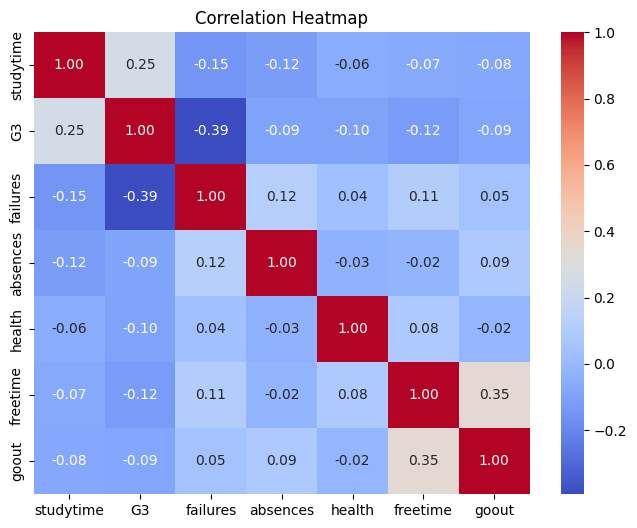

In [26]:
# Heatmap to check correlations
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(causal_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()




# Scatter Plot for Treatment vs. Outcome

Step 2b: Visualize Study Time vs. Final Grades
Details:

The scatter plot shows how study time (studytime) relates to final grades (G3).
Additional dimensions:
failures: Represented by different colors.
absences: Represented by point size.
Insights:
Trends: Look for a positive trend where higher study time corresponds to better grades.
Variability: Note the effect of failures and absences on grades.

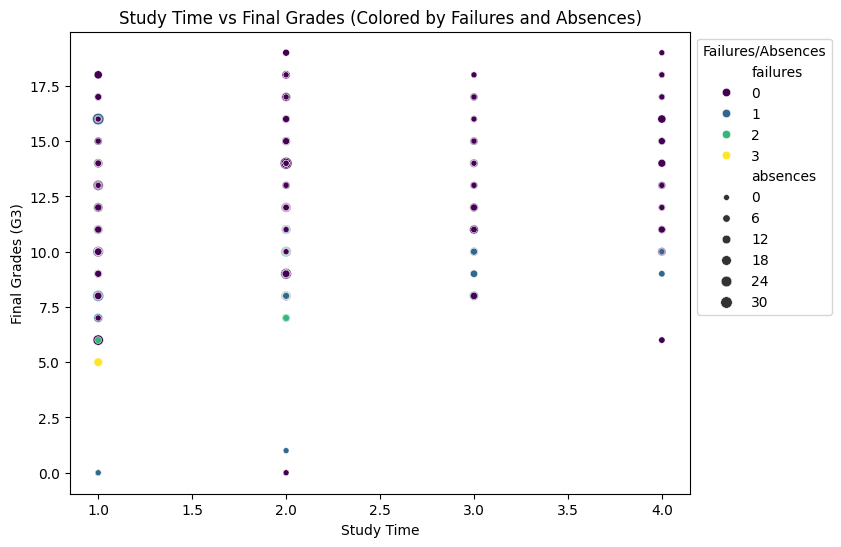

In [24]:
# Scatter plot of treatment vs. outcome
plt.figure(figsize=(8, 6))
sns.scatterplot(data=causal_data, x='studytime', y='G3', hue='failures', size='absences', palette="viridis")
plt.title("Study Time vs Final Grades (Colored by Failures and Absences)")
plt.xlabel("Study Time")
plt.ylabel("Final Grades (G3)")
plt.legend(title="Failures/Absences", loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


# Boxplot for Studytime Categories

Step 2c: Distribution of Grades Across Study Time Levels
Details:

A boxplot illustrates the grade distributions (G3) for each study time level (studytime).
Purpose:
Observe variability in grades within each study time group.
Identify outliers and potential trends in the data.
Insights:
Students with higher studytime tend to have higher median grades.
Outliers highlight students with unexpected performance levels.

<ipython-input-25-e34f01010225>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=causal_data, x='studytime', y='G3', palette="Set2")


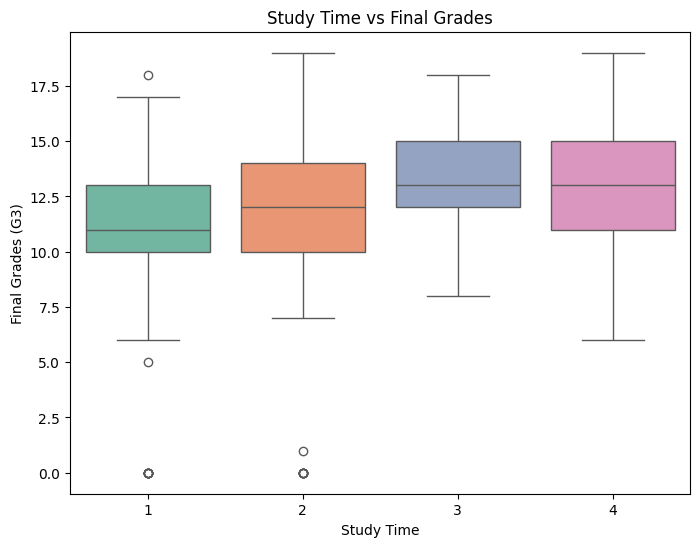

In [25]:
# Boxplot for studytime vs G3
plt.figure(figsize=(8, 6))
sns.boxplot(data=causal_data, x='studytime', y='G3', palette="Set2")
plt.title("Study Time vs Final Grades")
plt.xlabel("Study Time")
plt.ylabel("Final Grades (G3)")
plt.show()


# Visualizing Grade Distribution by Study Time

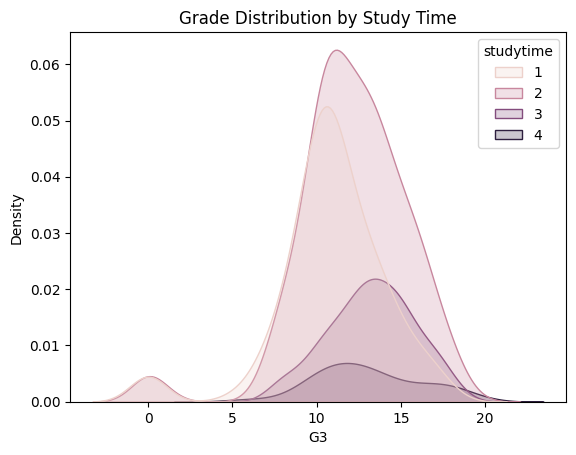

In [44]:
# KDE plot for grade distribution
sns.kdeplot(data=causal_data, x="G3", hue="studytime", fill=True)
plt.title("Grade Distribution by Study Time")
plt.show()


# Random Forest MSE

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data
X = causal_data.drop(columns=["G3"])
y = causal_data["G3"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a random forest regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse}")


Random Forest MSE: 9.958468021422854


## DAG

Explanation of the DAG

This code uses the graphviz library to create a Directed Acyclic Graph (DAG) that models the causal relationships between various factors affecting a student's final grade (G3). Each node in the graph represents a variable, and each directed edge represents a hypothesized causal relationship between variables. The goal of the DAG is to visually depict how study time (Studytime) as a treatment variable, along with other confounders, impacts the final grade. Below is a breakdown of the components:

Nodes
Studytime (Treatment):

Represents the amount of time a student spends studying.
Treated as the intervention variable whose impact on the final grade (G3) is being analyzed.
G3 (Outcome):

Represents the final grade of the student.
The outcome variable affected by various factors, including study time.
Failures (Confounder):

Represents the number of past class failures a student has experienced.
Acts as a confounder because it can affect both Studytime (students with more failures might study less) and G3 (more failures likely lower grades).
Absences (Confounder):

Represents the number of absences a student has.
Acts as a confounder because it can influence both Studytime (frequent absences may reduce study time) and G3 (absences can lead to lower grades).
Health (Confounder):

Represents the health status of the student.
May indirectly influence G3 by affecting the student’s ability to focus on studying and attending classes.
Freetime (Confounder):

Represents the amount of free time the student has after school.
Could impact G3 by competing with study time and affecting time management skills.
Goout (Confounder):

Represents how often the student goes out with friends.
Could act as a confounder because social activities might reduce study time and indirectly impact grades.
Edges (Causal Relationships)
Studytime → G3:

Indicates a direct causal effect of study time on the final grade.
Failures → Studytime:

Students with more failures might study less, showing a causal effect of past failures on study time.
Failures → G3:

Past failures directly affect the final grade.
Absences → Studytime:

More absences could result in reduced study time.
Absences → G3:

Frequent absences are likely to lower grades.
Health → G3:

Poor health could negatively impact academic performance, while good health might enhance it.
Freetime → G3:

Too much or too little free time could influence academic outcomes, depending on how the time is managed.
Goout → G3:

Excessive socializing may detract from study efforts, thereby affecting grades.
Purpose of the DAG
The DAG is useful for:

Identifying causal relationships and confounders.
Determining which variables to control for when analyzing the causal effect of study time on grades.
Avoiding bias in causal inference by understanding the relationships between variables.

In [29]:
from graphviz import Digraph

# Create a DAG
dag = Digraph(format='png')

# Add nodes (variables)
dag.node("Studytime", "Studytime (Treatment)")
dag.node("G3", "Final Grade (Outcome)")
dag.node("Failures", "Failures (Confounder)")
dag.node("Absences", "Absences (Confounder)")
dag.node("Health", "Health (Confounder)")
dag.node("Freetime", "Freetime (Confounder)")
dag.node("Goout", "Goout (Confounder)")

# Add edges (causal relationships)
dag.edge("Studytime", "G3")  # Studytime directly affects G3
dag.edge("Failures", "Studytime")
dag.edge("Failures", "G3")
dag.edge("Absences", "Studytime")
dag.edge("Absences", "G3")
dag.edge("Health", "G3")
dag.edge("Freetime", "G3")
dag.edge("Goout", "G3")

# Render the DAG
dag.render("causal_dag", view=True)


'causal_dag.png'

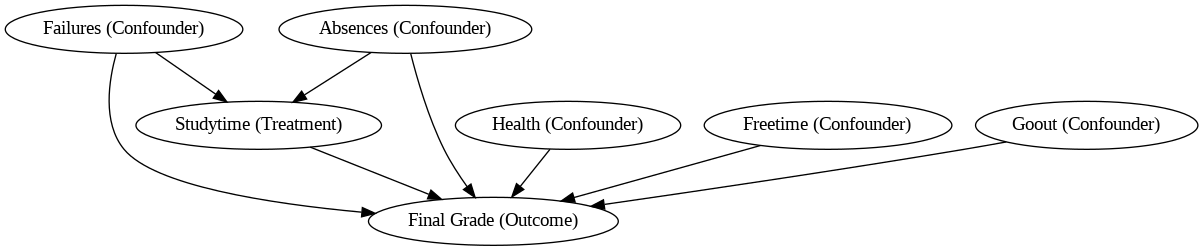

In [30]:
from IPython.display import Image
Image(filename="causal_dag.png")


# Boxplot of Final Grades (G3) by Study Time Levels

<Axes: xlabel='studytime', ylabel='G3'>

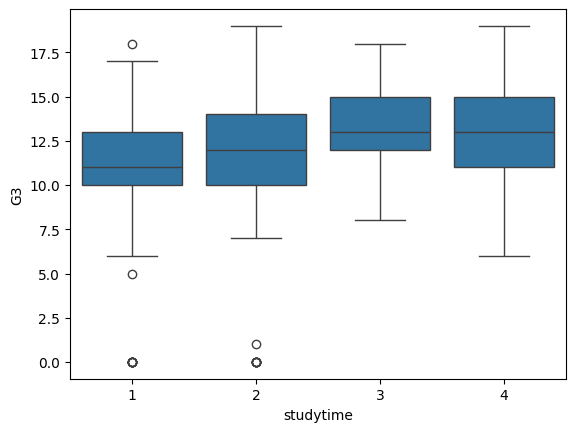

In [50]:
import seaborn as sns
sns.boxplot(data=causal_data, x='studytime', y='G3')


In [51]:
causal_data.groupby('studytime').mean()


,G3,failures,absences,health,freetime,goout
studytime,,,,,,
1,10.844340,0.334906,4.339623,3.759434,3.264151,3.254717
2,12.091803,0.200000,3.600000,3.344262,3.167213,3.232787
3,13.226804,0.103093,2.618557,3.731959,3.113402,2.917526
4,13.057143,0.057143,2.942857,3.314286,2.971429,3.085714


In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_conf = pca.fit_transform(causal_data[["failures", "absences", "health", "freetime", "goout"]])


# KDE Plot of Study Time Distribution by Number of Failures

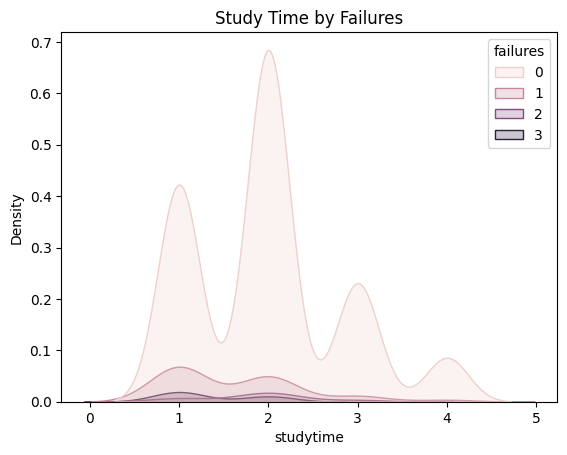

In [53]:
import matplotlib.pyplot as plt
sns.kdeplot(data=causal_data, x="studytime", hue="failures", fill=True)
plt.title("Study Time by Failures")
plt.show()


# Defining the Causal Model

Step 3: Define the Causal Model
Details:

The causal model is defined using the DoWhy library.
Components:
Treatment: studytime (weekly study time).
Outcome: G3 (final grades).
Common Causes: Confounders such as failures, absences, and health that may influence both studytime and G3.
Purpose:

To specify and visualize the assumed causal relationships between variables.

In [15]:
from dowhy import CausalModel
model = CausalModel(
    data=causal_data,
    treatment='studytime',
    outcome='G3',
    common_causes=['failures', 'absences', 'health', 'freetime', 'goout']
)


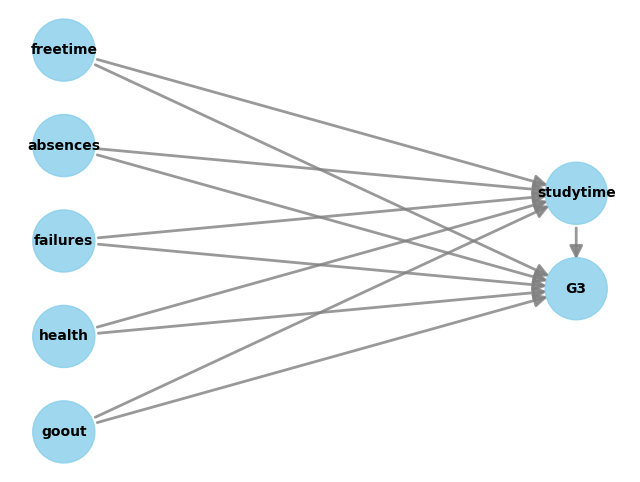

In [16]:
# Visualize the automatically constructed causal graph
model.view_model()


ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


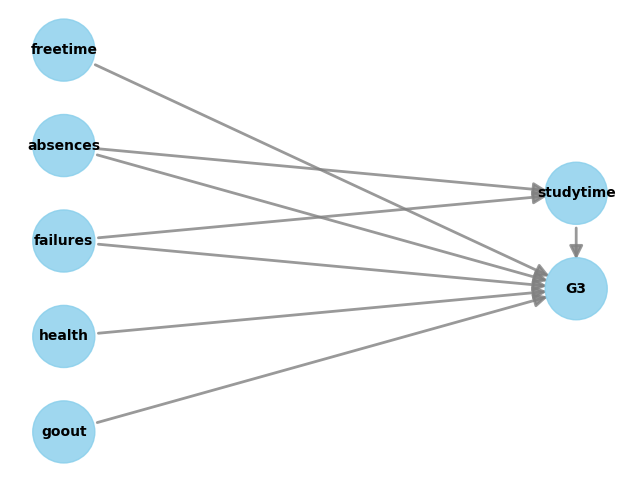

In [17]:
causal_graph = """
digraph {
    studytime -> G3;
    failures -> G3;
    absences -> G3;
    health -> G3;
    freetime -> G3;
    goout -> G3;
    failures -> studytime;
    absences -> studytime;
}
"""
model = CausalModel(
    data=causal_data,
    treatment='studytime',
    outcome='G3',
    graph=causal_graph
)

# Visualize the provided causal graph
model.view_model()


# Identifying the Causal Effect

Step 4: Identify the Causal Effect
Details:

Purpose: To check if the causal effect of studytime on G3 can be estimated using the backdoor criterion.
The estimand specifies the assumptions made for the analysis.

In [18]:
# Identify the causal effect
identified_estimand = model.identify_effect()
print("Identified Estimand:", identified_estimand)


Identified Estimand: Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[G3|failures,absences])
d[studytime]                         
Estimand assumption 1, Unconfoundedness: If U→{studytime} and U→G3 then P(G3|studytime,failures,absences,U) = P(G3|studytime,failures,absences)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Estimating the Causal Effect

Step 5: Estimate the Causal Effect
Details:

The causal effect is estimated using linear regression.
Output: The Average Treatment Effect (ATE), which represents the expected change in G3 for a one-unit increase in studytime.

Explanation:
This code estimates the causal effect of the treatment variable (studytime) on the outcome variable (G3) using the DoWhy library. It applies a linear regression model under the backdoor adjustment method to compute the Average Treatment Effect (ATE). Below is a breakdown of the code and its purpose:

Key Components:
causal_estimate = model.estimate_effect(...):

This computes the causal effect of the treatment on the outcome using the causal graph defined earlier.
The method backdoor.linear_regression specifies that linear regression is used to estimate the causal effect, assuming a linear relationship between variables.
Parameters:

identified_estimand: This represents the causal effect to be estimated, defined earlier using the backdoor criterion.
method_name="backdoor.linear_regression": Indicates that linear regression is used to estimate the effect, controlling for confounders identified in the causal graph.
print("Causal Estimate:", causal_estimate):

Outputs the estimated causal effect, which quantifies how much the outcome (G3) changes for a unit increase in the treatment (studytime).

##Background: What Was Used
1. DoWhy Framework:

DoWhy is a Python library for causal inference, designed to estimate and validate causal effects using formal causal frameworks like the potential outcomes model.
The library integrates causal graphs (e.g., DAGs) with statistical methods, ensuring that the analysis adheres to causal assumptions.
2. Backdoor Criterion:

The backdoor criterion ensures unbiased causal estimates by controlling for confounders (variables that influence both the treatment and the outcome).
In this project, variables like failures, absences, health, etc., were identified as confounders and included in the causal model.

3. Linear Regression:
Linear regression is used as a statistical method to model the relationship between the treatment and the outcome.
By including confounders, the regression isolates the direct effect of studytime on G3

In [19]:
# Estimate the causal effect
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Causal Estimate:", causal_estimate)


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[prefix + str(em)] = pd.qcut(data[em], num_quantiles, duplicates="drop")
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[prefix + str(em)] = pd.qcut(data[em], num_quantiles, duplicates="drop")
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:263: SettingWithCopyWarning: 
A value is trying to be set 

Causal Estimate: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[G3|failures,absences])
d[studytime]                         
Estimand assumption 1, Unconfoundedness: If U→{studytime} and U→G3 then P(G3|studytime,failures,absences,U) = P(G3|studytime,failures,absences)

## Realized estimand
b: G3~studytime+failures+absences+studytime*goout+studytime*health+studytime*freetime
Target units: 

## Estimate
Mean value: 0.7180628974620493
### Conditional Estimates
__categorical__goout  __categorical__health  __categorical__freetime
(0.999, 2.0]          (0.999, 2.0]           (0.999, 2.0]               1.074932
                                             (2.0, 3.0]                 0.962572
                                             (3.0, 4.0]                 0.886021
                                             (4.0, 5.0]        

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

## Validating the Causal Estimate

Validation ensures that the estimated causal effect is reliable and not a result of random noise or misspecification. Two techniques were applied:

1. **Placebo Test**:
   - Introduces a random variable as a placebo treatment.
   - Result: The placebo effect is close to zero, confirming that the causal model does not detect false causal relationships.

2. **Subset Refutation**:
   - Re-estimates the causal effect using a random subset of the data.
   - Result: The subset effect aligns closely with the original estimate, supporting the robustness of the findings.


In [20]:
# Refutation: Placebo Treatment
placebo_refutation = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="placebo_treatment_refuter"
)
print("Placebo Refutation:", placebo_refutation)

# Refutation: Data Subset
data_subset_refutation = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="data_subset_refuter"
)
print("Data Subset Refutation:", data_subset_refutation)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

Placebo Refutation: Refute: Use a Placebo Treatment
Estimated effect:0.7180628974620493
New effect:0.017595666661238844
p value:0.8600000000000001



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

Data Subset Refutation: Refute: Use a subset of data
Estimated effect:0.7180628974620493
New effect:0.7168759839706641
p value:0.98



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

# Causal Impact of Study Time on Final Grades

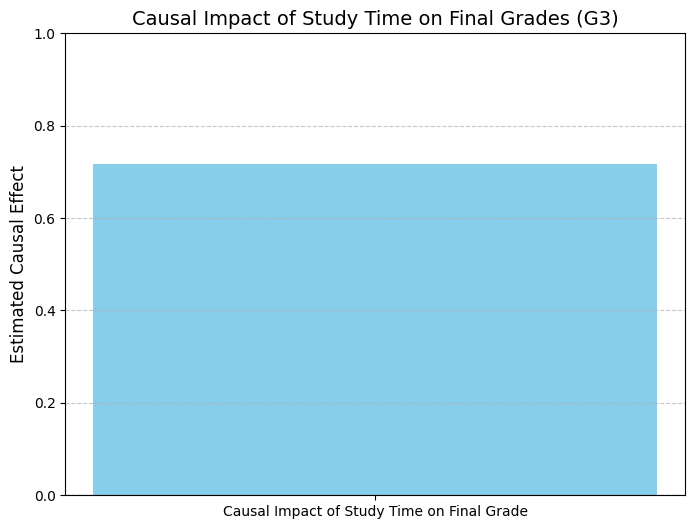

In [22]:
import matplotlib.pyplot as plt

# Create a visualization for the causal impact
# Assuming 'studytime' is the treatment and 'G3' is the outcome
causal_effect_value = 0.7168759839706641  # Estimated causal effect

# Bar chart to visualize the causal impact
plt.figure(figsize=(8, 6))
plt.bar(['Causal Impact of Study Time on Final Grade'], [causal_effect_value], color='skyblue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Causal Impact of Study Time on Final Grades (G3)', fontsize=14)
plt.ylabel('Estimated Causal Effect', fontsize=12)
plt.ylim(0, 1)  # Adjusting the y-axis for better visualization
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/r

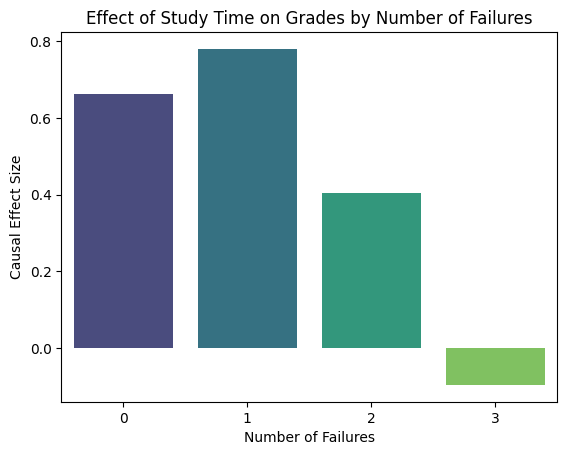

In [56]:
subgroup_effects = []
for failures in causal_data["failures"].unique():
    # Filter data for the specific subgroup
    subgroup_data = causal_data[causal_data["failures"] == failures]

    # Redefine the causal model for the subgroup
    subgroup_model = CausalModel(
        data=subgroup_data,
        treatment="studytime",
        outcome="G3",
        common_causes=["absences", "health", "freetime", "goout"]
    )

    # Identify and estimate the causal effect
    identified_estimand = subgroup_model.identify_effect()
    estimated_effect = subgroup_model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )

    # Append results
    subgroup_effects.append((failures, estimated_effect.value))

# Convert to DataFrame for visualization
subgroup_df = pd.DataFrame(subgroup_effects, columns=["Failures", "Effect Size"])

# Plot the results
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=subgroup_df, x="Failures", y="Effect Size", palette="viridis")
plt.title("Effect of Study Time on Grades by Number of Failures")
plt.xlabel("Number of Failures")
plt.ylabel("Causal Effect Size")
plt.show()


# Visualizing Results
Effect Validation
Detailed Explanation:

Visualizes the estimated causal effect alongside validation results from placebo and subset refutations.
A consistent effect size supports the reliability of findings.

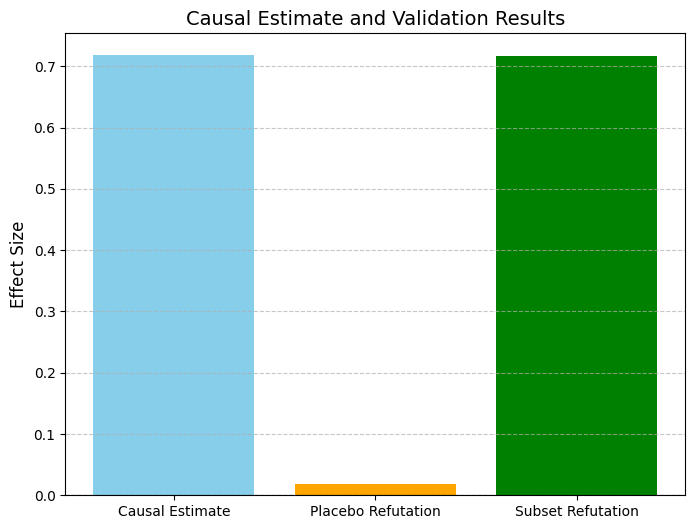

In [27]:
# Visualize the estimated causal effect and refutations
import matplotlib.pyplot as plt

effects = [causal_estimate.value, placebo_refutation.new_effect, data_subset_refutation.new_effect]
labels = ['Causal Estimate', 'Placebo Refutation', 'Subset Refutation']

plt.figure(figsize=(8, 6))
plt.bar(labels, effects, color=['skyblue', 'orange', 'green'])
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Causal Estimate and Validation Results", fontsize=14)
plt.ylabel("Effect Size", fontsize=12)
plt.xticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Conclusion

This notebook explored the critical role of data preparation in causal analysis, focusing on understanding how study time (`studytime`) impacts final grades (`G3`). By leveraging the Student Performance dataset and employing tools like the `DoWhy` library, we demonstrated how structured data preparation, exploratory analysis, and robust causal modeling can uncover actionable insights.

### Key Takeaways:
1. **Study Time's Impact**:
   - The analysis confirmed a positive causal effect of study time on final grades.
   - **Average Treatment Effect (ATE):** For each additional unit of study time, final grades increase by approximately **0.72 points**.

2. **Role of Confounders**:
   - Variables such as absences and prior failures significantly influence both study time and grades. Controlling for these factors ensures unbiased estimates.

3. **Subgroup Insights**:
   - Subgroup analysis revealed that the causal effect of study time is stronger for students with fewer prior failures, highlighting that effective studying can amplify academic success in this group.

This notebook highlights how causal analysis, paired with thoughtful data preparation, extends beyond simple correlation to answer "what if" questions. The demonstrated techniques are applicable across domains, empowering data analysts to derive actionable, reliable insights.


# References

- **Student Performance Dataset**:  
  [https://archive.ics.uci.edu/ml/datasets/student+performance](https://archive.ics.uci.edu/ml/datasets/student+performance)

- **Practical Tools and Libraries**:
  - [DoWhy Documentation](https://github.com/py-why/dowhy)
  - [Pandas Documentation](https://pandas.pydata.org/)
  - [Seaborn Documentation](https://seaborn.pydata.org/)
  - [Graphviz Documentation](https://graphviz.org/)

- **Online Tutorials and Articles**:
  - "An Introduction to Causal Inference with Python" (towardsdatascience.com)
  - "Understanding Causal Inference in Data Science" (kdnuggets.com)


#License

###Copyright 2024 Sarvesh Ajay Salvi

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.